# Hlasování

## Nastavení prostředí

In [1]:
# Specifické příkazy pro prostředí Google Colab
if 'google.colab' in str(get_ipython()):
        import os, sys
        os.chdir('/content')
        # Stažení knihovny
        ! ls parlamentikon || git clone "https://github.com/parlamentikon/parlamentikon.git" --branch main
        os.chdir('/content/parlamentikon/notebooks')

In [2]:
instalace_zavislosti = True
if instalace_zavislosti:
    ! pip install -r ../requirements.txt 1>/dev/null

You should consider upgrading via the '/home/borjana/.venv/finance/bin/python -m pip install --upgrade pip' command.


In [3]:
instalace_knihovny = False
if instalace_knihovny:
    ! pip install ..  1>/dev/null
else:
    # Přidání cesty pro lokální import knihovny
    import sys, os
    sys.path.insert(0, os.path.abspath('..'))

## Import knihoven

In [4]:
from datetime import datetime, timedelta

import plotly.express as px
import plotly.graph_objects as go

import pandas as pd
import numpy as np

In [5]:
from parlamentikon.Hlasovani import Organy
from parlamentikon.PoslanciOsoby import Poslanci
from nastav_notebook import nastav_pandas, clean_layout, clean_layout_with_x_spikes, clean_layout_with_y_spikes, clean_layout_with_xy_spikes, categorical_scale1

In [6]:
# nastavení výpisu, například zobrazení delších textů v sloupcích tabulek
nastav_pandas()

In [7]:
# formát výpisu data
format_den = "%d. %m. %Y"

## Parametry

In [8]:
# Data se budou pokaždé znovu stahovat z achivu PS
stahni=True

# Budeme analyzovat poslední volební období
zvolene_volebni_obdobi = None

## Načtení tabulek

In [9]:
vsechny_organy = Organy(volebni_obdobi=-1)
snemovny = vsechny_organy[vsechny_organy.nazev_typ_organ_cz == 'Parlament'].od_organ.dt.year.sort_values()

poslanci = {}
for i in snemovny:
    poslanci[i] = Poslanci(volebni_obdobi=i)

2021-05-23:20:13:13 INFO     [utility.py:21] Stahuji 'https://www.psp.cz/eknih/cdrom/opendata/poslanci.zip'.
2021-05-23:20:13:14 INFO     [utility.py:21] Stahuji 'https://www.psp.cz/eknih/cdrom/opendata/poslanci.zip'.
2021-05-23:20:13:15 WARNING  [Snemovna.py:149] While merging 'funkce' with 'typ_funkce': Dropping ['nazev_typ_organ_en__typ_funkce', 'id_typ_organ__typ_funkce', 'typ_id_typ_organ__typ_funkce', 'nazev_typ_organ_cz__typ_funkce', 'typ_organ_obecny__typ_funkce'] because of abundance.
2021-05-23:20:13:16 INFO     [utility.py:21] Stahuji 'https://www.psp.cz/eknih/cdrom/opendata/poslanci.zip'.
2021-05-23:20:13:17 WARNING  [Snemovna.py:149] While merging 'funkce' with 'typ_funkce': Dropping ['nazev_typ_organ_en__typ_funkce', 'id_typ_organ__typ_funkce', 'typ_id_typ_organ__typ_funkce', 'nazev_typ_organ_cz__typ_funkce', 'typ_organ_obecny__typ_funkce'] because of abundance.
2021-05-23:20:13:18 INFO     [utility.py:21] Stahuji 'https://www.psp.cz/eknih/cdrom/opendata/poslanci.zip'.
20

In [15]:
#df = pd.DataFrame()
#for i in snemovny:
#    pos = poslanci[i][poslanci[i].od_parlament.dt.date == poslanci[i].snemovna.od_organ.date()]
#    pos_dle_pohlavi = pos.groupby('pohlavi').size().to_dict() #.reset_index(name='pocet').to_dict() #.set_name(i) #.set_name(i)#.rename(i)
#    pos_dle_pohlavi['snemovna'] = i
#    pos_dle_pohlavi['hovertemplate_zeny'] = f"Sněmovna: {i}" +'<br>Pohlaví: ženy<br>Počet: %{y}<extra></extra>'
#    pos_dle_pohlavi['hovertemplate_muzi'] = f"Sněmovna: {i}" +'<br>Pohlaví: muži<br>Počet: %{y}<extra></extra>'
#    df = df.append(pos_dle_pohlavi, ignore_index=True)
#df['snemovna'] = df.snemovna.astype('category')
#df = df.set_index('snemovna')


#fig=go.Figure(data=[
#    go.Bar(name='ženy', x=df.index, y=df['žena'], hovertemplate=df['hovertemplate_zeny']),
#    go.Bar(name='muži', x=df.index, y=df['muž'], hovertemplate=df['hovertemplate_muzi'])
#])
#layout = go.Layout(
#    title="Počty poslanců ve sněmovně dle pohlaví [na začátku volebního období]",    
#    plot_bgcolor="#FFFFFF",
#    #hovermode="x",
#    #hoverdistance=100, # Distance to show hover label of data point
#    #spikedistance=1000, # Distance to show spike
#    xaxis=dict(
#        title="sněmovna",
#        linecolor="#BCCCDC",
#        type='category'
#    ),
#    yaxis=dict(
#        title="počet",
#        linecolor="#BCCCDC",
#        showspikes=True,
#        spikethickness=1,
#        spikedash="dot",
#        spikecolor="#999999",
#        spikemode="across",
#    )
#)

#fig.update_layout(layout)

#fig.update_layout(barmode='stack')
#fig.show()

In [16]:
def pohlavi_dle_snemovny(snemovna):
    x = poslanci[snemovna]

    zeny_od = x[x.pohlavi == 'žena'].groupby('od_parlament').size().to_frame('zeny_od').rename_axis(index={'od_parlament': 'datum'})
    zeny_do = x[x.pohlavi == 'žena'].groupby('do_parlament').size().to_frame('zeny_do').rename_axis(index={'do_parlament': 'datum'})
    if snemovna < 2002:
        zeny_do.index = zeny_do.index.shift(1, freq='D')

    muzi_od = x[x.pohlavi == 'muž'].groupby('od_parlament').size().to_frame('muzi_od').rename_axis(index={'od_parlament': 'datum'})
    muzi_do = x[x.pohlavi == 'muž'].groupby('do_parlament').size().to_frame('muzi_do').rename_axis(index={'do_parlament': 'datum'})
    if snemovna < 2002:
        muzi_do.index = muzi_do.index.shift(1, freq='D')

    df = zeny_od.merge(muzi_od, how='outer', on='datum').merge(muzi_do, how='outer', on='datum').merge(zeny_do, how='outer', on='datum').sort_index()
    df = df.fillna(0)
    df['zeny_od'], df['zeny_do'] = df['zeny_od'].astype(int), df['zeny_do'].astype(int)
    df['muzi_od'], df['muzi_do'] = df['muzi_od'].astype(int), df['muzi_do'].astype(int)

    df['zeny_cnt'] = df['zeny_od'].cumsum() - df['zeny_do'].cumsum()
    df['muzi_cnt'] = df['muzi_od'].cumsum() - df['muzi_do'].cumsum()
    df['check_cnt'] = df['zeny_cnt'] + df['muzi_cnt']
    
    if (len(df) > 1) and (df.iloc[-1].check_cnt == 0):
        df.iloc[-1, df.columns.get_loc('zeny_cnt')] = df.iloc[-2].zeny_cnt
        df.iloc[-1, df.columns.get_loc('muzi_cnt')] = df.iloc[-2].muzi_cnt
        df['check_cnt'] = df['zeny_cnt'] + df['muzi_cnt']

    df['gender_ratio'] = 100 * df['zeny_cnt'] / (df['zeny_cnt'] + df['muzi_cnt'])

    df['snemovna'] = snemovna
    
    return df

In [21]:
podily = []
for snemovna in snemovny:
    podily.append(pohlavi_dle_snemovny(snemovna))

podily_df = pd.concat(podily, join='outer')
podily_df.index = podily_df.index.strftime("%Y-%m-%d %H:%M")

! mkdir -p "../docs/data"
export_path = "../docs/data/pohlavi_dle_snemovny.csv"
podily_df.to_csv(export_path)
! ls -l {export_path}

podily_df

-rw-rw-r-- 1 borjana borjana 6278 kvě 23 20:34 ../docs/data/pohlavi_dle_snemovny.csv


,zeny_od,muzi_od,muzi_do,zeny_do,zeny_cnt,muzi_cnt,check_cnt,gender_ratio,snemovna
datum,,,,,,,,,
1992-06-06 00:00,20,180,0,0,20,180,200,10.000000,1992
1993-11-10 00:00,0,0,0,1,19,180,199,9.547739,1992
1993-11-11 00:00,0,1,0,0,19,181,200,9.500000,1992
1995-05-24 00:00,0,0,1,0,19,180,199,9.547739,1992
1995-05-25 00:00,0,1,0,0,19,181,200,9.500000,1992
...,...,...,...,...,...,...,...,...,...
2021-01-26 00:00,0,0,1,0,46,153,199,23.115578,2017
2021-01-26 14:00,0,1,0,0,46,154,200,23.000000,2017
2021-03-01 00:00,0,1,0,1,45,155,200,22.500000,2017


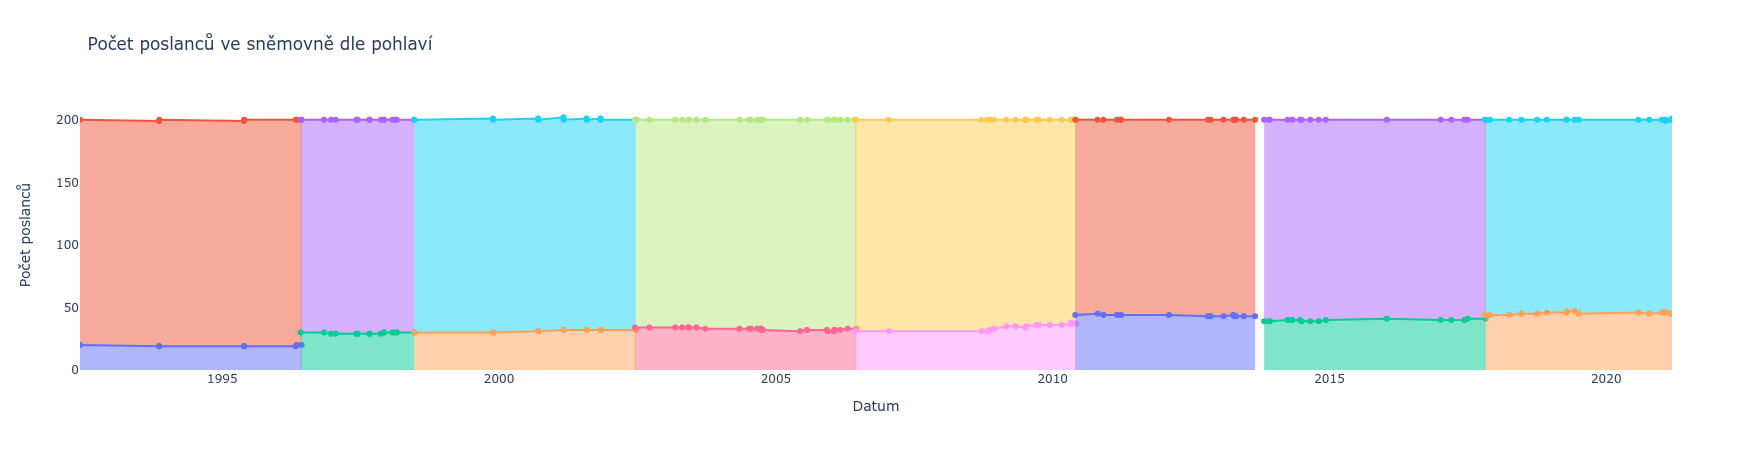

In [13]:
fig = go.Figure()

for snemovna in snemovny:
    df = pohlavi_dle_snemovny(snemovna)
    hovertemplate_zeny = f"Sněmovna: {snemovna}" +'<br>Datum: %{x|%d. %m. %Y}<br>Pohlaví: ženy<br>Počet: %{y}<extra></extra>'
    hovertemplate_muzi = f"Sněmovna: {snemovna}" +'<br>Datum: %{x|%d. %m. %Y}<br>Pohlaví: muži<br>Počet: %{y}<extra></extra>'
    fig.add_trace(go.Scatter(
        x = df.index,
        y = df.zeny_cnt,
        mode = 'markers+lines',
        #line = dict(shape='linear'),
        hoverinfo = 'text',
        hovertemplate=hovertemplate_zeny,
        name=f"ženy ({snemovna})",
        stackgroup=snemovna
    ))
    fig.add_trace(go.Scatter(
        x = df.index,
        y = df.muzi_cnt,
        name = f"muži ({snemovna})",
        hoverinfo = 'text',
        hovertemplate=hovertemplate_muzi,
        mode = 'markers+lines',
        #line = dict(shape='linear'),
        stackgroup=snemovna
    ))

layout = go.Layout(
    title="Počet poslanců ve sněmovně dle pohlaví",    
    plot_bgcolor="#FFFFFF",
    hovermode="x",
    xaxis=dict(title="Datum"),
    yaxis=dict(title="Počet poslanců")
)

fig.update_layout(layout)
fig.update_layout(showlegend=False)
fig.show()


In [37]:
print(f"Poslední běh notebooku: {datetime.now().strftime('%d.%m.%Y %H:%M:%S')}.")

Poslední běh notebooku: 23.03.2021 21:58:57.
